In [40]:
import sys 
import subprocess 
import pkgutil

def pip_install(pkg):
    if pkg.replace('-', '_') not in {m.name for m in pkgutil.iter_modules()}:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

for p in ['torch', 'matplotlib', 'numpy', 'transformers', 'tqdm', 'requests']:
    try:
        pip_install(p)
    except Exception as e:
        print(f'Warning: could not ensure install for {p}: {e}')

Input sequence -> tokenisation -> Cache Available? 
-> Yes -> Retrieve from cache -> Generate Token
-> No -> Compute KV Pairs -> Store in Cache -> Generate Token

The above code will ignore dependency versions and will install latest available releases

In [41]:
import math
import time
import os
import json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [42]:
import requests
# URL for the Shakespeare dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file_path = "input.txt"

# Only download if the file doesn't exist yet
if not os.path.exists(file_path):
    print("Downloading dataset...")
    response = requests.get(url)
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(response.text)
    print("Download complete.")
else:
    print("File already exists.")

File already exists.


In [43]:
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Length of dataset in characters: {len(text)}")
print(f"First 100 characters:\n{text[:100]}")

Length of dataset in characters: 1115394
First 100 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [44]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [45]:
string_to_integer = {ch:i for i,ch in enumerate(chars)}
integer_to_string = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [string_to_integer[c] for c in s]
decode = lambda l: ''.join([integer_to_string[i] for i in l])

print(encode("Hello"))
print(decode(encode("Hello")))

[20, 43, 50, 50, 53]
Hello


Self attention Recap

A minimal Transformer Block stack with multi-head self-attention

Shapes:
- Input tokens ```(B, T)```
- Embeddings ```(B, T, C)```
- Attention per head QKV ```(B, T, head_size)```
- Attention weights ```(B, T, T)``` with causal mask

This baseline recomputes keys/values for the entire prefix at every generation step, which becomes costly as T grows.

- B - **Batch size** processing B number of distinct chunks of text at once
- T - **Sequence Length** Each chunk has T number of characters or tokens
- C - **Vocab Size/ Channels** The total C number of unique tokens or characters

In [46]:
block_size = 1024
embed_size = 128
num_heads = 4
num_layers = 2
dropout = 0.0

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        self.head_size = head_size

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(1, 2) / math.sqrt(self.head_size)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] ==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v  # (B, T, head_size)
        return out

In [47]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        head_size = embed_size // num_heads
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.cat([h(x) for h in self.heads], dim=-1)
        x = self.dropout(self.proj(x))
        return x
    
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = MultiHeadAttention(num_heads)
        self.ff = FeedForward()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)
    
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x
    
class BaselineModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_size)
        self.pos_emb = nn.Embedding(block_size, embed_size)
        self.blocks = nn.Sequential(*[Block() for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embed_size)
        self.head = nn.Linear(embed_size, vocab_size)

    def forward(self, idx):
        B, T = idx.shape
        tok = self.token_emb(idx)
        pos = self.pos_emb(torch.arange(T, device=idx.device))
        x = tok + pos
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens):
        # Recompute over the entire prefix each step (No Cache)
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]  # Crop to context window
            logits = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_idx], dim=1)
        return idx

In [48]:
baseline = BaselineModel(vocab_size).to(device)
print(baseline)

BaselineModel(
  (token_emb): Embedding(65, 128)
  (pos_emb): Embedding(1024, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,

Now since the inference happens autoregressively, we do not have to compute the key and Value pairs everytime we predict the next token! We could use the already computed KV pair 

So KV-cache stores previously computed Keys and Values and reuses them accross autoregressive steps.

- Feed only one new token per step
- Add its KV to cache, queries attend to cached keys and values
- Complexity per step becomes roughly constant (Depends on max context), rather than growing with sequence length recomputation

Here its fixed-size caches of shape (B, block_size, head_size)

In [49]:
class CachedHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.head_size = head_size
        # Caches allocated lazily on first use
        self.k_cache = None
        self.v_cache = None
        self.cache_index = 0    
    
    def reset_cache(self):
        self.k_cache = None
        self.v_cache = None
        self.cache_index = 0
    
    def forward(self, x, caching=False):
        B, T, C = x.shape  # typically T==1 during cached generation
        k = self.key(x)  # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)
    
        if not caching:
            # Baseline path (full prefix, causal mask)
            wei = q @ k.transpose(1, 2) / math.sqrt(self.head_size)  # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)

            tril = torch.tril(torch.ones(T, T, device=x.device))  # Dont look into the future
            wei = wei.masked_fill(tril == 0, float('-inf'))
            
            wei = F.softmax(wei, dim=-1)
            wei = self.dropout(wei)
            out = wei @ v
            return out
    
        # Cached path: append new K/V and attend over all cached keys
        if self.k_cache is None or self.v_cache is None:
            # Create a tensor of shape (B, block_size, head_size)
            # Block size is the MAX length the model can handle
            self.k_cache = torch.zeros(B, block_size, self.head_size, device=x.device)
            self.v_cache = torch.zeros(B, block_size, self.head_size, device=x.device)
            self.cache_index = 0
    
        # Place new K/V into cache (rolling if needed)
        if self.cache_index + T <= block_size:
            self.k_cache[:, self.cache_index:self.cache_index+T, :] = k
            self.v_cache[:, self.cache_index:self.cache_index+T, :] = v
        else:
            # This is if we run out of space
            shift = self.cache_index + T - block_size
            self.k_cache[:, :-shift, :] = self.k_cache[:, shift:, :].clone()
            self.v_cache[:, :-shift, :] = self.v_cache[:, shift:, :].clone()
            self.k_cache[:, -T:, :] = k
            self.v_cache[:, -T:, :] = v
    
        self.cache_index = min(self.cache_index + T, block_size)  # Move the index pointer forward
    
        # Query attends over cached keys: shape (B, 1, cache_len)
        # q is the current token's query with shape (B, 1, head_size)
        # Reduces from O(n^2) to O(n) per new token
        wei = q @ self.k_cache.transpose(1, 2) / math.sqrt(self.head_size)
        wei = F.softmax(wei[:, :, :self.cache_index], dim=-1)
        wei = self.dropout(wei)
        out = wei @ self.v_cache[:, :self.cache_index, :]
        return out

So here we have `reset_cache` so that we can reset the key and value cache before generating the new sentence so basically say "Hello!! How are" then the next word is 'you?' so we can use the KV cache of "Hello!! How are" from the previous computation! But, after we are done with this sentence we might have to clear out the cache for a completely new sentence like "The cat" which is irrelevant to the KV pair of "Hello!! How are you?" 

For the forward pass we have kept two different modes - With caching and without caching!!
Both of them have the same setup with,
- B (Batch) - How many sequences you are processing
- T (Time) - The number of tokens you are feeding in so without caching, T is the whole prompt length and with caching, T is almost always 1 (Just the newest token)
- C (Channels) - The embedding size

1. **Without Caching** - It calculates the relationship between every token and every other token. So if T is 1000 then it calculates 10000 x 1000 matrix making it expensive!

2. **With Caching** - If the cache is empty we create a big storage for this KV pairs to store upto block_size as that is the Max length the model can handle. (Similar to bringing a empty bookshelf which can hold block_size amount of books). Then we take the new K and V of the new token and put them into the bookshelf. So `k - (B, 1, head_size)` and `self.k_cache - (B, block_size, head_size)` we insert k into self.cache at position cache_index. This way we do not have a square matric but a single row of attention scores to see "How much does this new token care about all previous tokens?"

In [50]:
class CachedMultiHeadAttention(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        # We chop the big embedding vector into smaller chunks, process them separately, adn glue them back later
        head_size = embed_size // num_heads
        self.heads = nn.ModuleList([CachedHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(dropout)
    
    def reset_cache(self):
        for h in self.heads:
            h.reset_cache()
    
    def forward(self, x, caching=False):
        if caching:
            # Input x goes into Head_1 and it projects it down to head_size and does the attention math, outputs shape (B, T=1, head_size)
            # Similarly with all the num_heads and finally concat it together to return back tot he original size
            x = torch.cat([h(x, caching=True) for h in self.heads], dim=-1)
        else:
            x = torch.cat([h(x, caching=False) for h in self.heads], dim=-1)
        x = self.dropout(self.proj(x))
        return x
        
class CachedBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = CachedMultiHeadAttention(num_heads)
        self.ff = FeedForward()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)
    def reset_cache(self):
        self.sa.reset_cache()
    def forward(self, x, caching=False):
        x = x + self.sa(self.ln1(x), caching=caching)
        x = x + self.ff(self.ln2(x))
        return x
    
class KVCacheModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # Input layer - Convert IDs into vectors (Size C)
        self.token_emb = nn.Embedding(vocab_size, embed_size)
        # Position Layer - Teaches the model order
        self.pos_emb = nn.Embedding(block_size, embed_size)
        # Stack of Transformer Blocks with CachedBlock instead of regular blocks
        self.blocks = nn.ModuleList([CachedBlock() for _ in range(num_layers)])
        # Normalise
        self.ln_f = nn.LayerNorm(embed_size)
        # Convert Vectors (Size C) back to  Probability Scores (Size V)
        self.head = nn.Linear(embed_size, vocab_size)
    
    def reset_cache(self):
        # It tells Block 1 to rest which tells its num_heads to rest its KV tensors
        for b in self.blocks:
            b.reset_cache()
    
    def forward(self, idx, caching=False, start_pos=0):
        B, T = idx.shape
        tok = self.token_emb(idx)
        pos_indices = torch.arange(start_pos, start_pos + T, device = idx.device)
        pos = self.pos_emb(pos_indices)
        x = tok + pos
        for b in self.blocks:
            x = b(x, caching=caching)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits
    
    @torch.no_grad()
    def generate_cached(self, idx, max_new_tokens):
        # One token at a time; reuse K/V
        self.eval()
        self.reset_cache()
        # Prefill - We pass the entire prompt (idx) first to fill the cache.
        # The start_pos is 0 because we are starting from the beginning.
        logits = self(idx, caching=True, start_pos=0)
        
        # We only care about the last token's prediction to start the loop
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_idx], dim=1)

        # DECODE LOOP
        for _ in range(max_new_tokens - 1): # -1 because we generated one above
            # calculate where we are currently
            # If idx has 5 tokens, the NEW token will be at position 5 (0-indexed)
            # We subtract 1 because we haven't added the *newest* token to idx yet
            current_pos = idx.shape[1] - 1 

            # Only pass the LAST token (T=1)
            x_input = idx[:, -1:]
            
            # Pass current_pos to the model
            logits = self(x_input, caching=True, start_pos=current_pos)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_idx], dim=1)
        return idx

In [51]:
kvmodel = KVCacheModel(vocab_size).to(device)
print(kvmodel)

KVCacheModel(
  (token_emb): Embedding(65, 128)
  (pos_emb): Embedding(1024, 128)
  (blocks): ModuleList(
    (0-1): 2 x CachedBlock(
      (sa): CachedMultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x CachedHead(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
     

In [52]:
def benchmark_models(start_text='Once upon a time', steps_list=(100, 300, 600)):
    results = []
    with torch.no_grad():
        for steps in steps_list:
            # Prepare initial context of length 1 from start_text (last char)
            x = torch.tensor([[string_to_integer[start_text[-1]]]], dtype=torch.long, device=device)

            t0 = time.time()
            out1 = baseline.generate(x.clone(), max_new_tokens=steps)
            t1 = time.time() - t0

            t0 = time.time()
            out2 = kvmodel.generate_cached(x.clone(), max_new_tokens=steps)
            t2 = time.time() - t0

            results.append((steps, t1, t2))
    return results

results = benchmark_models(steps_list=(100, 300, 600))
print(results)

[(100, 0.09750795364379883, 0.07226729393005371), (300, 0.43438005447387695, 0.22146105766296387), (600, 1.2931103706359863, 0.58327317237854)]


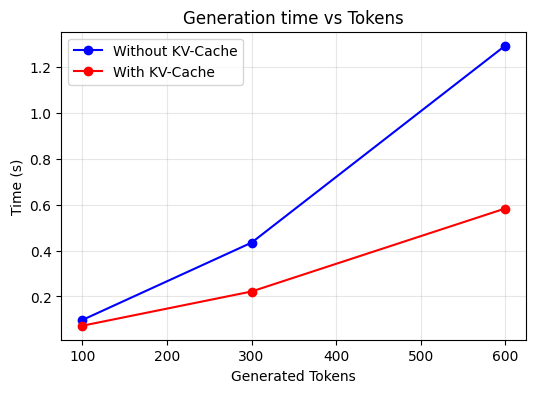

In [53]:
steps = [r[0] for r in results]
no_cache = [r[1] for r in results]
with_cache = [r[2] for r in results]

plt.figure(figsize=(6,4))
plt.plot(steps, no_cache, 'o-b', label='Without KV-Cache')
plt.plot(steps, with_cache, 'o-r', label='With KV-Cache')
plt.xlabel('Generated Tokens')
plt.ylabel('Time (s)')
plt.title('Generation time vs Tokens')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

For smaller models and short sequences, speedups may be moderate. As sequence length and embedding size grows, recomputation overhead dominates the baseline, and KV-cache yields larger gains.

- Cache size vs Context Length - Ensure cache arrays match the maximum context you expect, **roll or evict when full**
- Batching - When generating multiple sequences, maintain per-sequence cache indices
- Quality vs Speed - Caching changes compute paths at inference but not model quality, Quality depends on training, not the cache itself